## Project Solution Structure
1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images
2. Apply distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline


### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

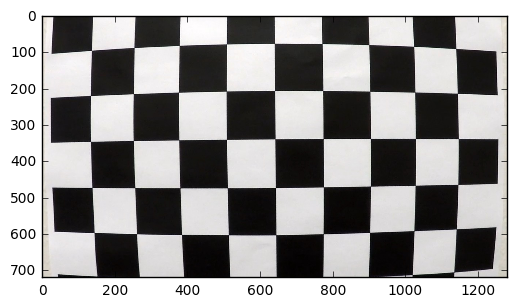

In [10]:
#Check the chessboard pattern
image_test = mpimg.imread("./camera_cal/calibration1.jpg")
plt.imshow(image_test)

#### corners in x direction = nx = 9 ; corners in y direction = ny = 6

In [11]:
import glob

nx = 9
ny = 6

#Defining the object points
objpoints = []
imgpoints = []

#prepare object points by known dimensions of chessboard pattern
objp = np.zeros((9*6,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

images = glob.glob("./camera_cal/calibration*.jpg")

for fname in images:
    
    #Read in the image and convert to grayscale
    image = mpimg.imread(fname)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Try to detect corners
    ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)
    
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

# Use the corners from all the test images and obtain the calibration parameters        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)


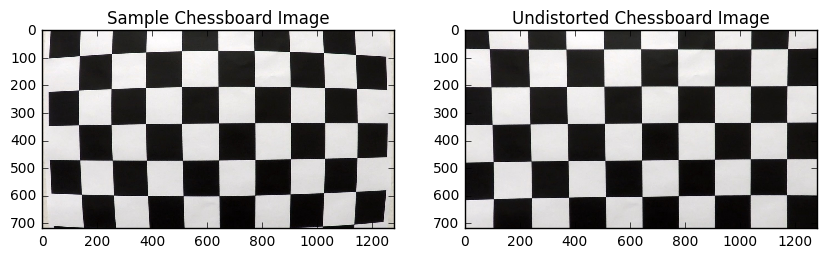

In [268]:
# Check how good the camera calibration parametes are by undistorting the sample image loaded above
undist = cv2.undistort(image_test,mtx,dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(image_test)
ax1.set_title('Sample Chessboard Image')
ax2.imshow(undist)
ax2.set_title('Undistorted Chessboard Image')

f.savefig("output_images/camera_calibration.png")

### 2. Apply distortion correction to raw images.

(720, 1280, 3)


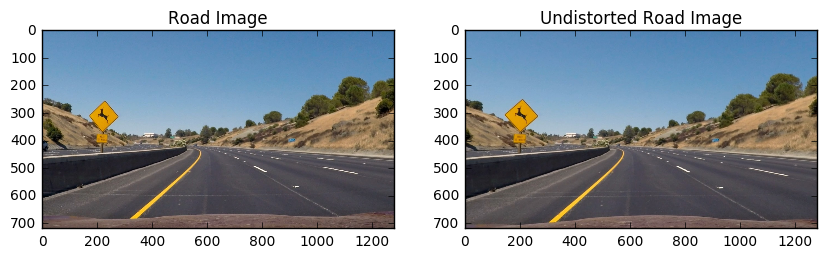

In [269]:
# Undistort the road images
road_image = mpimg.imread("./test_images/test2.jpg")
print(road_image.shape)
undist_road_image = cv2.undistort(road_image,mtx,dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,10))
ax1.imshow(road_image)
ax1.set_title('Road Image')
ax2.imshow(undist_road_image)
ax2.set_title('Undistorted Road Image')

f.savefig("output_images/undistorted_road_image_example.png")




### 3. Use color transforms, gradients, etc., to create a thresholded binary image.

In [17]:
# Define functions for all the masks to be applied to get the image ready for persepective transform
def apply_gradient_thresh(gray, orientation ='x', kernel_size = 5, thresh = (0,255)):
    
    #Apply gradient based on orientation setting
    if orientation == "x":
        grad_thresh = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize= kernel_size)
    elif orientation == "y":
        grad_thresh = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize= kernel_size)
    
    #We don't care about direction of the gradient for our application. So take absolute values.
    grad_thresh = np.absolute(grad_thresh)
    
    #Rescale to 8bit as suggested in the lecture
    grad_thresh_rescaled = np.uint8(255*grad_thresh/np.max(grad_thresh))
    
    #Apply the min and max threshold limits and generate the binary image
    binary_output = np.zeros_like(grad_thresh)
    binary_output[(grad_thresh_rescaled > thresh[0]) & (grad_thresh_rescaled<thresh[1])] = 1
    
    return binary_output
    

def apply_gradient_mag_thresh(gray, kernel_size = 5, thresh = (0,255)):
    
    #Get x and y gradients to calculate gradient magnitude
    gradx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize= kernel_size)
    grady = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize= kernel_size)
    
    #Calculate gradient magnitude
    grad_mag = np.sqrt(np.square(gradx) + np.square(grady))
    
    #Rescale to 8bit as suggested in the lecture
    grad_mag_rescaled = np.uint8(255 * grad_mag / np.max(grad_mag))
    
    #Apply the min and max threshold limits and generate the binary image
    binary_output = np.zeros_like(grad_mag)
    binary_output[(grad_mag_rescaled > thresh[0])&(grad_mag_rescaled < thresh[1])] = 1
    
    return binary_output


def apply_gradient_orientation_thresh(gray, kernel_size = 5, thresh = (0, np.pi/2)):
    
    #Get x and y gradients to calculate gradient orientation
    gradx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize= kernel_size)
    grady = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize= kernel_size)
    
    #To disable bookkeeping error
    with np.errstate(divide='ignore', invalid='ignore'):
        #Calculate the gradient orientation (absolute)
        grad_orient = np.absolute(np.arctan(grady/gradx))
        
    #Apply the threshold limits and generate the binary image
    binary_output = np.zeros_like(grad_orient)
    binary_output[(grad_orient > thresh[0])&(grad_orient < thresh[1])] = 1
    
    return binary_output


def apply_polygon_mask(image, vertices):
    
    mask = np.zeros_like(image)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    #filling pixels inside the polygon defined by "vertices" with the fill color chosen above   
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #Return the image after applying the mask (To retain the pixels only within the polygonal region of interest)
    binary_output = cv2.bitwise_and(image,mask)
    
    return binary_output

In [210]:
def get_road_lanes(image):
    
    #Smoothen the image to remove any sharp irregularities
    # Always safe to start  with a kernel size of 5
    gaussian_kernel_size = 5 
    image = cv2.GaussianBlur(image, (gaussian_kernel_size, gaussian_kernel_size), 0)
    
    #From the lecture material, it is pretty clear that the best way to detect the lines is by using the gradient
    #threshold mixture of direction, magnitude and orientation.
    #Also, converting to HLS color and space and thresholding on Saturation (S part of HLS) also yields good results
    #tracking lane markings even in slightly shadowy images. 
    #So lets do both and combine them for best results
    
    #Threshold values obtained by experimentation and from forum.
    sobel_kernel_size = 7
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    #Apply the thresholds
    
    binary_xthresh = apply_gradient_thresh(gray,orientation= "x",kernel_size=sobel_kernel_size,thresh=(10,255))
    binary_ythresh = apply_gradient_thresh(gray,orientation= "y",kernel_size=sobel_kernel_size,thresh=(60,255))
    binary_mag = apply_gradient_mag_thresh(gray,kernel_size=sobel_kernel_size,thresh=(40,255))
    binary_orient = apply_gradient_orientation_thresh(gray,kernel_size=sobel_kernel_size,thresh=(.65,1.05))
    
    #Combine all gradient thresholds
    grad_output = np.zeros_like(gray)
    grad_output[((binary_xthresh==1)&(binary_ythresh==1))|((binary_mag==1)&(binary_orient==1))]=1
    
    # Apply the color thresholding
    hls = cv2.cvtColor(image,cv2.COLOR_BGR2HLS)
    #get the s channel
    s = hls[:,:,2]
    #Threshold s channel
    color_output = np.zeros_like(grad_output)
    color_output[(s > 160)&( s < 255)] = 1
    
    #Combine gradient and color threshold
    final_threshold_image = np.zeros_like(color_output)
    final_threshold_image[(grad_output>0)|(color_output>0)]=1
    
    #Apply the polygon mask
    height = image.shape[0]
    width = image.shape[1]
    
    #Define the vertices
    vertex_left_bottom = (150,height-50)
    vertex_left_top = (560,450)
    vertex_right_top = (760,450)
    vertex_right_bottom = (width-150,height-50)
    
    vertices = np.array([[vertex_left_bottom,vertex_left_top,vertex_right_top,vertex_right_bottom]],dtype=np.int32)
    
    #Apply the mask
    lane_lines_image = apply_polygon_mask(final_threshold_image,vertices)
    
    return lane_lines_image

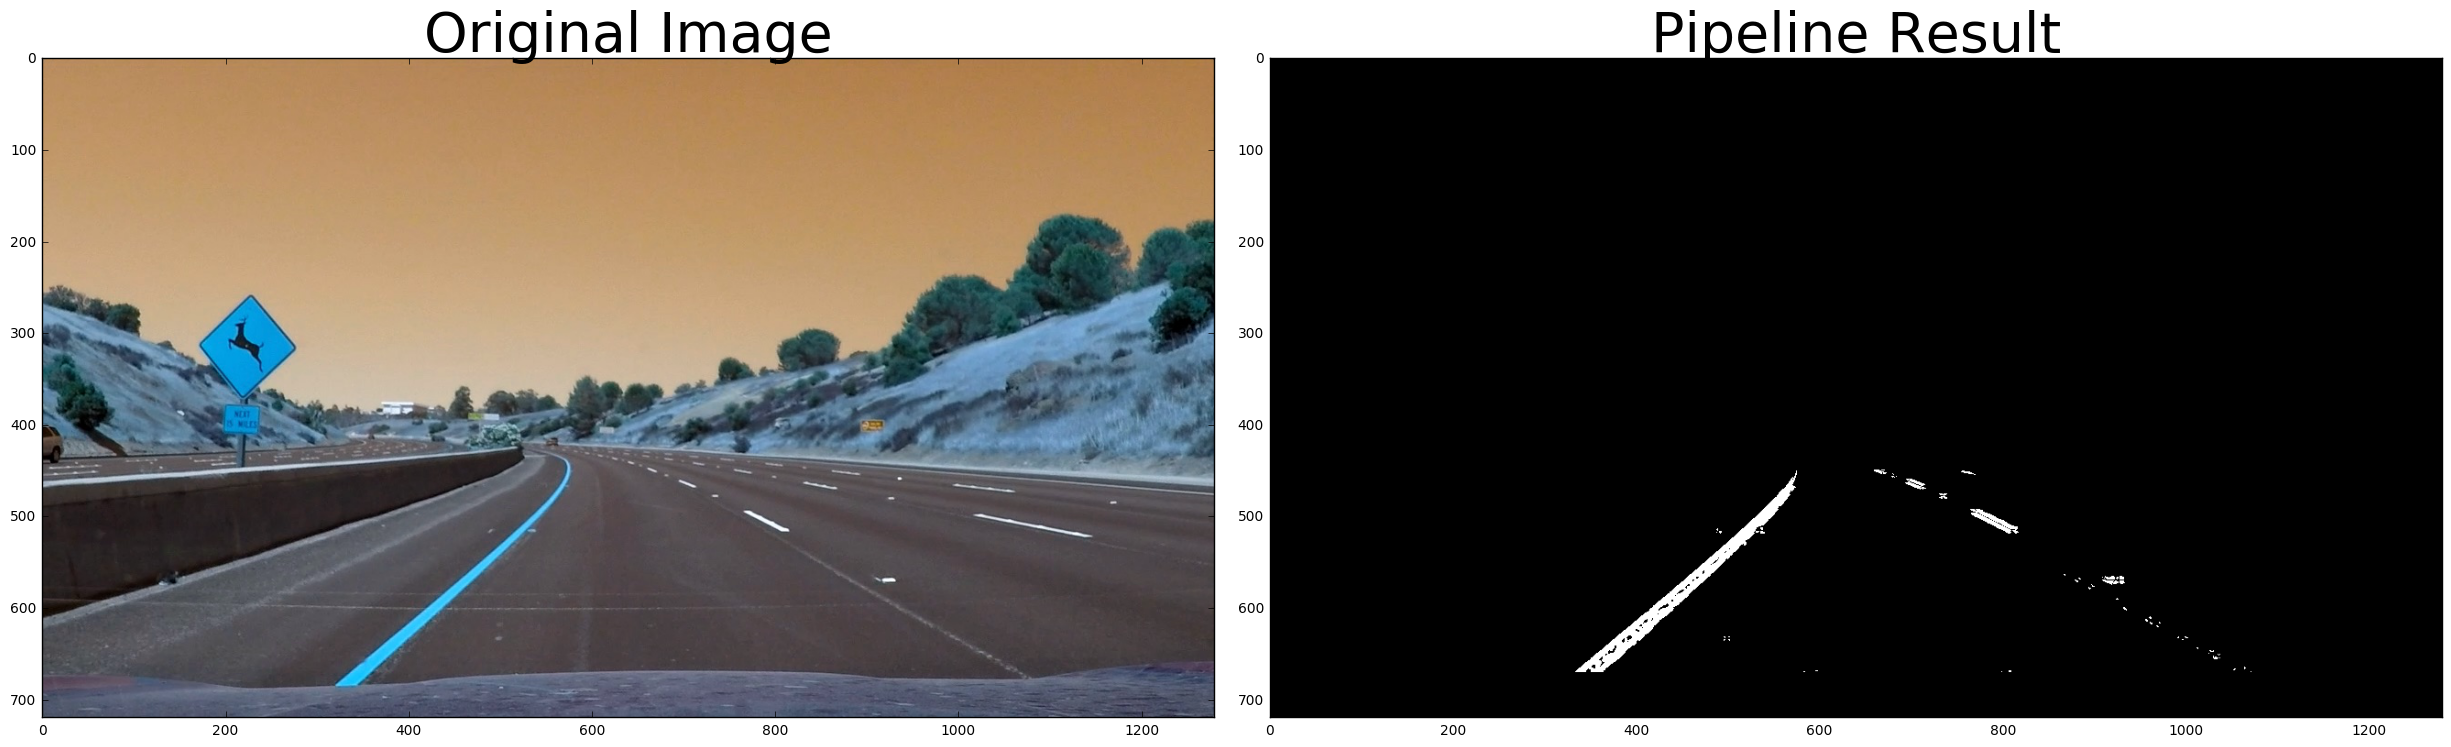

In [271]:
#Check the thresholding pipeline
fname = 'test_images/test2.jpg'
image = cv2.imread(fname)
result = get_road_lanes(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f.savefig("output_images/thresholding_pipeline_output.png")

### 4. Apply a perspective transform to rectify binary image ("birds-eye view").

In [212]:
#Now The thresholding is good enough. 
#Time to warp it to a ovehead projection (bird's eye view), so that we can fit the second order polynomial
#for the road lane

def warp_image(image,mtx,dist):
    
    #Define the source points same as vetices chosen for polygon mask
    height = image.shape[0]
    width = image.shape[1]
    
    vertex_left_bottom = (150,height-50)
    vertex_left_top = (560,450)
    vertex_right_top = (760,450)
    vertex_right_bottom = (width-150,height-50)
    
    src = np.array([vertex_left_bottom,vertex_left_top,vertex_right_top,vertex_right_bottom],dtype=np.float32)
    
    #Define the destination points
    offset = 100
    dst = np.array([[offset,height-offset], 
                      [offset,offset], 
                      [width-offset, offset], 
                      [width-offset, height-offset]],dtype=np.float32)
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    #Now we have all the parameters required.
    #First undistort the image and then warp
    
    #Undistort
    image_undist = cv2.undistort(image, mtx, dist)
    
    #warp
    image_warp = cv2.warpPerspective(image_undist, M, (width,height))
    
    return image_warp, M, Minv    
    

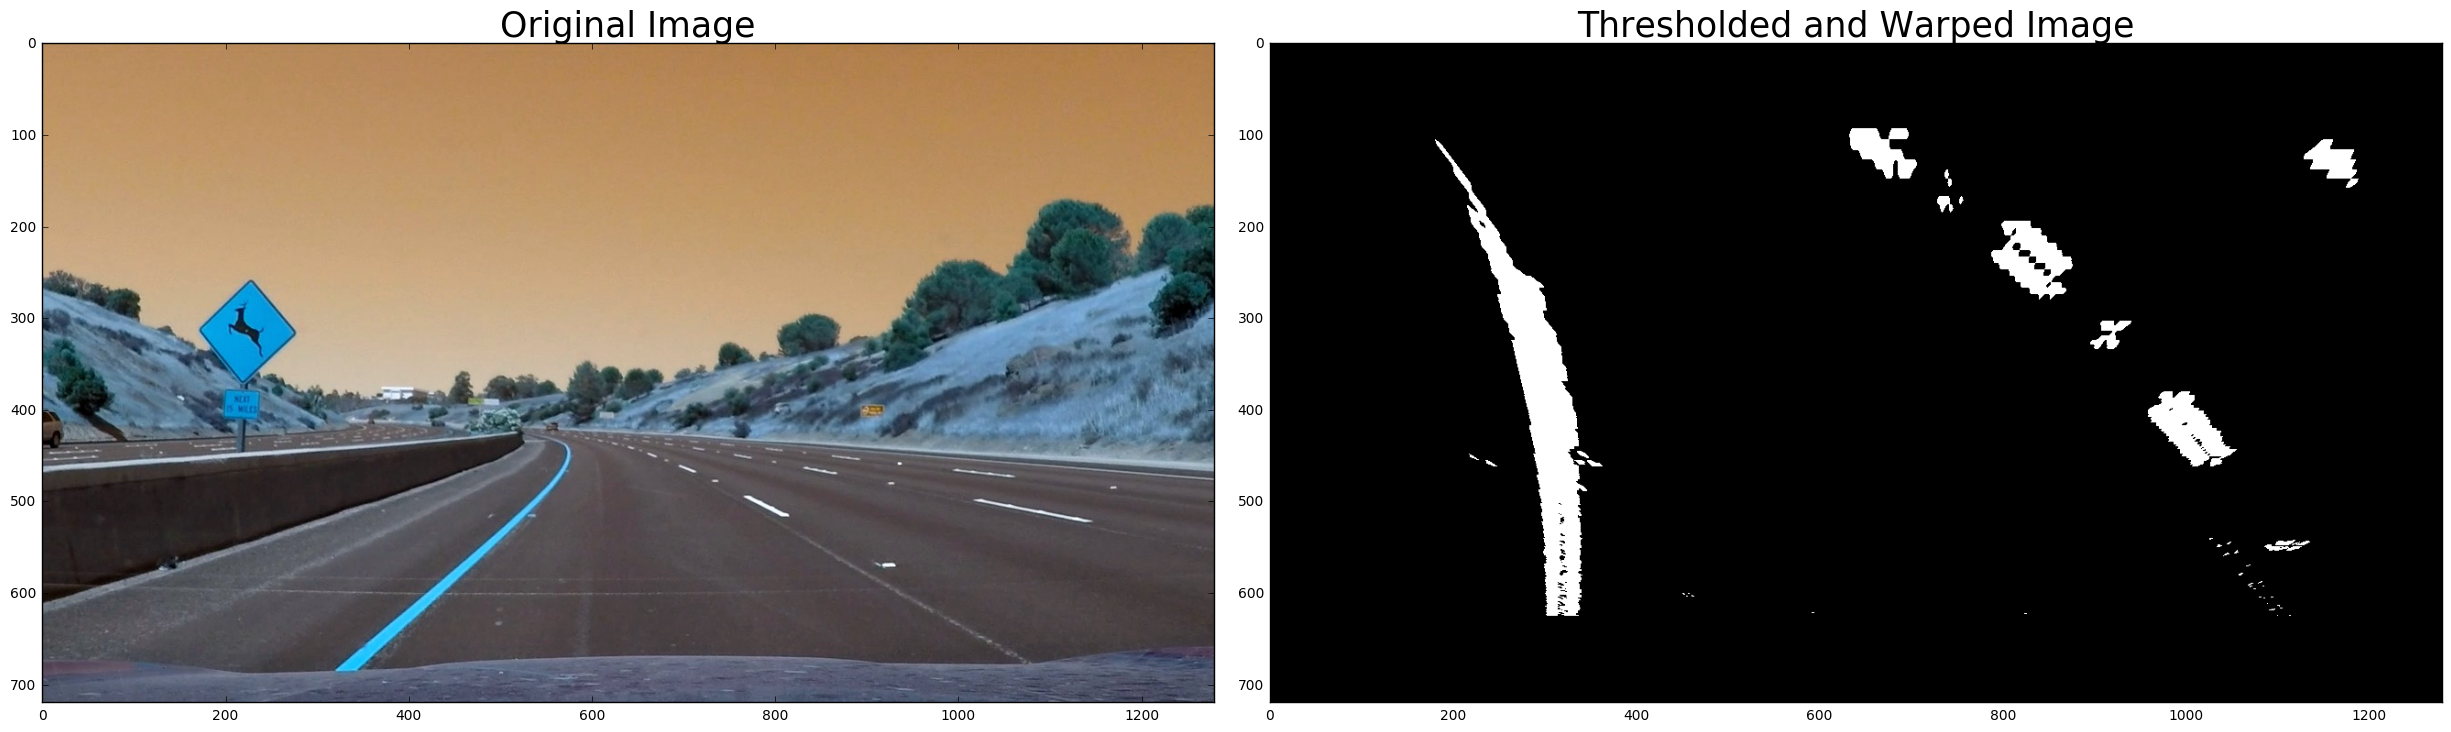

In [272]:
#Check warping on a test image
fname = 'test_images/test2.jpg'
image = cv2.imread(fname)
result = get_road_lanes(image)
result,M,Minv = warp_image(result,mtx,dist)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=25)

ax2.imshow(result, cmap='gray')
ax2.set_title('Thresholded and Warped Image', fontsize=25)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f.savefig("output_images/warped_image.png")


### 5. Detect lane pixels and fit to find the lane boundary.

In [232]:
#Define Line class as suggested in the lecture

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #polynomial coefficients log
        self.fits = np.zeros((10,3))
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #sanity value - True/False
        self.sanity = False
        #for keeping a moving average
        self.next_arrayIndex = 0
        #logging arrays full?
        self.arrayfull = False
        

In [246]:
#Functions for different stages in bestfit line detection and line fitting


def get_curvature(yvals, fitx):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.mean(yvals)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    fit_cr = np.polyfit(yvals*ym_per_pix, fitx*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) /np.absolute(2*fit_cr[0])
    return curverad

def sanity_check_lane_detections(current_radiusOfCurv, lane_object):
    #If previously the lane was detected, then the degree to which the radius of Curvature
    #is allowed to vary frame to frame is less
    if lane_object.detected:
        #Check if radius of curvature is varying within allowable limits
        if abs(current_radiusOfCurv/lane_object.radius_of_curvature - 1) < 0.15: #0.25
            lane_object.sanity = True
            
        else:
            lane_object.sanity = False 
        
    else:
    #If previously the lane was not detected, then the degree to which the radius of Curvature  
    # is allowed to vary frame to frame is slightly more
        if lane_object.radius_of_curvature:
            if abs(current_radiusOfCurv/lane_object.radius_of_curvature - 1) < 0.25: #0.4
                lane_object.sanity = True
            
            else:
                lane_object.sanity = False 
        
        else:
        #basecase - first detection
            lane_object.sanity = True


In [233]:
#Expecting a warped image here
def fit_line(binary_warped,left_lane,right_lane):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    # out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    y_value_sweep = np.linspace(0, 100, 101)*7.2

    if (left_lane.detected == False or right_lane.detected == False): 
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            ##cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            ##cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        left_fitx = left_fit[0]*y_value_sweep**2 + left_fit[1]*y_value_sweep + left_fit[2]
        right_fitx = right_fit[0]*y_value_sweep**2 + right_fit[1]*y_value_sweep + right_fit[2]
        
        left_curvature = get_curvature(yvals=y_value_sweep,fitx=left_fitx)
        right_curvature = get_curvature(yvals=y_value_sweep,fitx=right_fitx)
        
        sanity_check_lane_detections(left_curvature,left_lane)
        sanity_check_lane_detections(right_curvature,right_lane)
        
    
    else:
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        
        left_fit = left_lane.current_fit
        right_fit = right_lane.current_fit
        
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        left_fitx = left_fit[0]*y_value_sweep**2 + left_fit[1]*y_value_sweep + left_fit[2]
        right_fitx = right_fit[0]*y_value_sweep**2 + right_fit[1]*y_value_sweep + right_fit[2]
        
        left_curvature = get_curvature(yvals=y_value_sweep,fitx=left_fitx)
        right_curvature = get_curvature(yvals=y_value_sweep,fitx=right_fitx)
        
        sanity_check_lane_detections(left_curvature,left_lane)
        sanity_check_lane_detections(right_curvature,right_lane)
        
    if left_lane.sanity == True:
        left_lane.detected = True
        left_lane.current_fit = left_fit
        left_lane.radius_of_curvature = left_curvature
        left_lane.fits[left_lane.next_arrayIndex] = left_fit
        left_lane.next_arrayIndex = (left_lane.next_arrayIndex + 1)%10
        if left_lane.arrayfull == False:
            if left_lane.next_arrayIndex == 0:
                left_lane.arrayfull = True
    else:
        left_lane.detected = False
    
    if right_lane.sanity == True:
        right_lane.detected = True
        right_lane.current_fit = right_fit 
        right_lane.radius_of_curvature = right_curvature
        right_lane.fits[right_lane.next_arrayIndex] = right_fit
        right_lane.next_arrayIndex = (right_lane.next_arrayIndex + 1)%10
        if right_lane.arrayfull == False:
            if right_lane.next_arrayIndex == 0:
                right_lane.arrayfull = True
    else:
        right_lane.detected = False
    
    return
    

(720, 0)

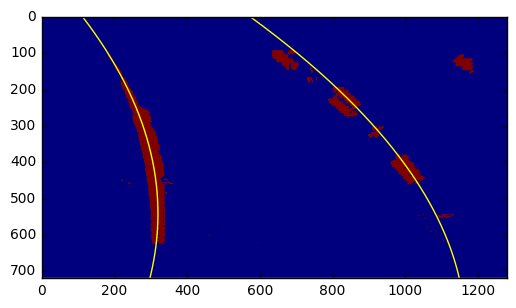

In [283]:
#Visualizing the line fit process

fname = 'test_images/test2.jpg'
image = cv2.imread(fname)
image_thresholded = get_road_lanes(image)
image_warped,M,Minv = warp_image(image_thresholded,mtx,dist)

left_lane = Line()
right_lane = Line()

fit_line(image_warped,left_lane,right_lane)

left_fit = left_lane.current_fit
right_fit = right_lane.current_fit
    
ploty = np.linspace(0, image_warped.shape[0]-1, image_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

imgplot = plt.imshow(image_warped)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


### 6. Determine the curvature of the lane and vehicle position with respect to center.

In [260]:
def process_image(image):
    
    image_thresholded = get_road_lanes(image)
    image_warped,M,Minv = warp_image(image_thresholded,mtx,dist)

    fit_line(image_warped,left_lane,right_lane)

    if (left_lane.arrayfull == True and right_lane.arrayfull == True):
        #Trying averaging over 5 pixels
        left_fit = np.mean(left_lane.fits,axis=0)
        right_fit = np.mean(right_lane.fits,axis=0)
        
    else:   
        left_fit = left_lane.current_fit
        right_fit = right_lane.current_fit
    

    ploty = np.linspace(0, image_warped.shape[0]-1, image_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(image_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    image_undist = cv2.undistort(image, mtx, dist)
    result = cv2.addWeighted(image_undist, 1, newwarp, 0.3, 0)
    
    #Put text on the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Curvature:{} m".format(int((left_lane.radius_of_curvature + right_lane.radius_of_curvature)/2))
    cv2.putText(result,text,(200,50), font, 1,(255,255,255),2)
    
    # Find the position of the car
    image_center = image.shape[1]/2
    predicted_center = (left_fitx[-40]+right_fitx[-40])/2
    
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension  
    
    position_of_car = (image_center - predicted_center)*xm_per_pix

    if position_of_car < 0:
        text = "Vehicle is {:.2f} m left of center".format(-position_of_car)
    else:
        text = "Vehicle is {:.2f} m right of center".format(position_of_car)
    cv2.putText(result,text,(200,100), font, 1,(255,255,255),2)
    

    return result

### 7. Warp the detected lane boundaries back onto the original image.

True

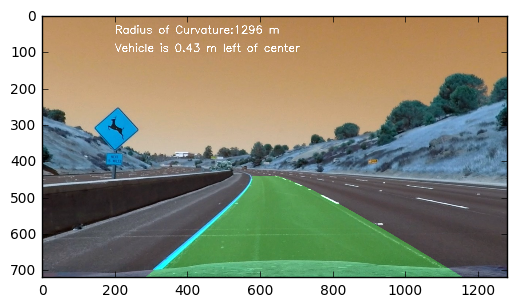

In [284]:
#Visualizing step 7 separately as everything is packaged into functions for easier processing of videos.
left_lane = Line()
right_lane = Line()

fname = 'test_images/test2.jpg'
image = cv2.imread(fname)
plt.imshow(process_image(image))
cv2.imwrite("output_images/lane_detection_overlapped_unto_original.png",process_image(image))

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [262]:
#Process video
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# Set up lines for left and right
left_lane = Line()
right_lane = Line()
white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [05:08<00:00,  3.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 5min 22s, sys: 1min 2s, total: 6min 24s
Wall time: 5min 9s


### Conclusion

1. The major portion of effort was in adjusting the threshold values and the region of interest and warping co-ordinates. Thanks to all the guidelines and standard values provided on the forum, this task is less daunting. With such fine calibration of numbers, we tend to sort of overfit (machine learning reference! :D ) for the current video. But, again for a given vehicle, its camera position and orientation, resulting in the unique imaging is unique to the vehicle. so, in that sense, fine tuning is acceptable. But, care should be taken to see that, good enough margins are given for varying road conditions (for example, if we set apex of the polygons by looking at a flat road image, this might mean that we only cover very little info if there is an elevated road). But, the margins also cannot be such that they accomodate every possible condition, then we cannot find good solutions for average situtaions. This is sort of a tradeoff... 

2. I implemented averaging over 10 frames to get a smoother lane marking. But, before this, I tried with no smoothing, and the detection just kept bouncing around. Tried higher number of frames also, but with higher number of frames,the detection takes that much longer to adjust to changes in road condition - if you are entering a curve, it takes longer to shift to curve mode from straight line mode and the same for exiting a curve into a straight lane. I found smoothening over 10 frames to be a good tradeoff in this case.

3. With the challenge videos, as soon as I saw the visuals I could relate to the first point above. Both the videos have different camera orientations and placements. So, with the same settings of polygonal region of interest, we would perform very badly on the challenge videos. So, we need to tweak the ROI and warping parameters for that setup. But, again as explained in 1st point, this is a reasonable thing to do.

4. Our approximations of distance measurements work well when esitmating valid curvatures. But, when it comes to straight lines, I have observed that curvature values tend to misbehave a bit. but, this could also be because that my lane detections are not perfect either..

5. All in all, a good project. good hands-on experience doing classic computer vision stuff. But, the frame rate is like 4-5 frames per second. This is a minor concern, but it is well expected, if you perform ton of customized processing for every single image. A good idea for this would be to use recent methods of advancement in deep learning,where we can do a precise detection for every, say 10 frames, and let the neural net fill in for the in-between frames. Since, we dont expect drastic changes in 10 frames!, I think this could work. :D 